<div class="alert alert-block alert-info">

<b>Thank you for contributing to TeachOpenCADD!</b>

</div>

<div class="alert alert-block alert-info">

<b>Set up your PR</b>: Please check out our <a href="https://github.com/volkamerlab/teachopencadd/issues/41">issue</a> on how to set up a PR for new talktorials, including standard checks and TODOs.

</div>

# T029 · Compound activity: Proteochemometrics

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Marina Gorostiola González, 2022, Computational Drug Discovery, Drug Discovery & Safety Leiden University (The Netherlands)
- Olivier J.M. Béquignon, 2022, Computational Drug Discovery, Drug Discovery & Safety Leiden University (The Netherlands)
- Willem Jespers, 2022, Computational Drug Discovery, Drug Discovery & Safety Leiden University (The Netherlands)

*The examples used in this talktorial template are taken from [__Talktorial T001__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) and [__Talktorial T002__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb).*

<div class="alert alert-block alert-info">

<b>Cross-referencing talktorials</b>: If you want to cross-reference to existing talktorials in your notebook, please use the following formatting: <b>Talktorial T000</b>.

</div>

## Aim of this talktorial

While activity data is very abundant for some protein targets, there are still a number of underexplored proteins where the use of machine learning (ML) for activity prediction is very difficult due to the lack of data. This issue can be solved leveraging similarities and differences between proteins. In this talktorial, we use Proteochemometrics modelling (PCM) to enrich our activity models with protein data to predict the activity of novel compounds against the four adenosine receptor isoforms (A1, A2A, A2B, A3).

### Contents in *Theory*

* Data preparation
    * Papyrus dataset
    * Molecule encoding: molecular descriptors
    * Protein encoding: protein descriptors

* Proteochemometrics (PCM)
    * Machine learning principles: regression
        * Splitting methods
        * Regression evaluation metrics
        * ML algorithm: Random Forest
    * Applications of PCM in drug discovery

### Contents in *Practical*

* Downlaod Papyrus dataset
* Data preparation
    * Filter activity data for targets of interest
    * Align target sequences
    * Calculate protein descriptors
    * Calculate compound descriptors
* Proteochemometrics modelling
    * Helper functions
    * Model training and validation

### References

* Papyrus scripts [github](https://github.com/OlivierBeq/Papyrus-scripts)
* Papyrus dataset preprint: [<i>ChemRvix</i> (2021)](https://chemrxiv.org/engage/chemrxiv/article-details/617aa2467a002162403d71f0)
* Molecular descriptors (Modred): [<i>J. Cheminf.</i>, 10, (2018)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)
* Protein descriptors (ProDEC) [github](https://github.com/OlivierBeq/ProDEC)
* Regression metrics [(Scikit learn)](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)
* XGBoost [Documentation](https://xgboost.readthedocs.io/en/stable/index.html)
* Proteochemometrics review: [<i>Drug Discov.</i> (2019), <b>32</b>, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub)



## Theory

To successfully apply PCM modelling, we need a large dataset of molecule-protein pairs with known bioactivity values, a way of describing molecules and proteins, and a ML algorithm to train a model. Then, we can make predictions for new molecule-protein pairs.

<b>NOTE:</b> PCM modelling is an extension of ligand-based modelling with ML described in <b>Talktorial T007</b>. Explore that talktorial to know more about the basic principle of activity prediction using ML.

<img src='images/PCM_model_text-01.png' width="1000">

*Figure 1:*
Proteochemometrics modelling construction from protein and molecular descriptors for which protein-compound pair bioactivity data is known.
Figure made by Marina Gorostiola González.

### Data preparation

#### Papyrus dataset

The Papyrus dataset is a highly curated compilation of bioactivity data intended for modelling in drug discovery. Apart from the bioactivity data contained in the ChEMBL database (see also  <b>Talktorial T001</b>), the Papyrus dataset contains binary data for classification tasks from the ExCAPE-DB, and bioactivity data from a number of kinase-specific papers (Figure 1).

The bioactivity data aggregated is standardized, repaired, and normalised to form the Papyrus dataset, which is updated with every new version of ChEMBL released. The Papyrus dataset contains "high quality" data associated to pChEMBL values for regression tasks and "low quality" data associated to an active/inactive label for classification tasks (read more about ML applications in <b>Talktorial T007</b>).

<img src='images/papyrus_workflow.png' width="1000">

*Figure 2:*
Papyrus dataset generation scheme.
Figure taken from: [<i>ChemRvix</i> (2021)](https://chemrxiv.org/engage/chemrxiv/article-details/617aa2467a002162403d71f0).

#### Molecule encoding: molecular descriptors

For the ML models used in PCM, molecules need to be converted into a list of features. In <b>Talktorial T007</b>, molecular fingerprints were introduced. In this talktorial, we will use a different type of representation that is often used on its own or in combination with fingerprints: molecular descriptors.

<b>Molecular descriptors</b> are the "final result of a logical and mathematical procedure, which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment" ([<i>J. Cheminf.</i>, 10, (2018)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)). These descriptors can be, for example, molecular weight, ring count, Eccentric Connectivity Index (calculated from the 2D structure), or Geometrical Index (calculated from the 3D structure).

In this talktorial, we use Modred as a software engine to calculate molecular descriptors. Modred calculates more than 1,800 molecular descriptors, including the ones implemented in RDKit, including an automatic preprocessing step that is common for all descriptors calculated. For simplicity, here we calculate only 4 types of descriptors from the vast list of possibilities from Modred, excluding their 3D representation. These include:

* <b>ABC Index</b>: 2 descriptors that represent the atom-bond connectivity index or the Graovac-Ghorbani atom-bond connectivity index (see Modred <code>ABCIndex</code> [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.ABCIndex.html))
* <b>Acid-Base</b>: 2 descriptors that count acidic and basic groups, respectively (see Modred <code>AcidBase</code> [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.AcidBase.html?highlight=acidbase))
* <b>Atom count</b>: 16 descriptors that represent a count of different types of atoms (see Modred <code>AtomCount</code> [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.AtomCount.html?highlight=atomcount))
* <b>Balaban J index</b>: 1 descriptor (included in RDkit), which represents a topological index (see Modred <code>BalabanJ</code> [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.BalabanJ.html?highlight=balaban#module-mordred.BalabanJ))

#### Protein encoding: protein descriptors

As done for molecules, the proteins of interest need to be converted to a list of features or protein descriptors. Protein descriptors used in PCM applications are commonly based on the protein sequence and represent physicochemical characteristics of the amino acids that make up the sequence (e.g. Z-scales). Other protein descriptors represent topological (e.g. St-scales) or electrostatic properties (e.g. MS-WHIM) of the protein sequence. Moreover, if structural information is available, protein descriptors can be derived from the 3D structure of the protein (e.g. sPairs) or the ligand-protein interaction in 3D (e.g. interaction fingerprints). Finally, with the widespread use of deep learning, protein embeddings can be obtained after parsing the protein sequence through the network (e.g. UniRep, AlphaFold embeddings).

For protein descriptors based on the protein sequence, an aspect to take into account is that for ML the length of the protein descriptor needs to be the same. However, most proteins do not have the same sequence length. To solve this issue, there are two main approaches:
* <b>Multiple sequence alignment</b>: when the whole protein wants to be incorporated to the model, a multiple sequence alignment can be performed. The final descriptor will have as many features as the number of features per amino acid multiplied by the number of aligned positions. To take into account, gaps in the alignment will receive zeroes in the descriptor.
* <b>Binding pocket selection</b>: To avoid unnecessary features, a binding pocket of the same length can be selected for each protein. Normally, the binding pocket selection is preceded by a multiple sequence alignment and driven by known structural or mutagenesis data.

Other options are available when proteins are not of the same family or do not share a binding pocket (see [<i>Drug Discov.</i> (2019), <b>32</b>, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub))

In this talktorial, we will focus on physicochemical protein descriptors, mainly <b>Z-scales</b> ([<i>J. Med. Chem</i>, 30 (1987)](https://pubs.acs.org/doi/10.1021/jm00390a003)). The Z-scales descriptor assigns three pre-determined values (Z<sub>1</sub>, Z<sub>2</sub>, Z<sub>3</sub>) to each amino acid in the sequence. The Z<sub>1</sub>, Z<sub>2</sub>, and Z<sub>3</sub> values are the first principal components of a principal component analysis (PCA) including 29 different physicochemical variables to characterize the amino acids.
Since we are calculating activity for four proteins with very high sequence similarity (Adenosine receptors A1, A2A, A2B, and A3), we will use <b>multiple sequence alignment</b> prior to calculation of the Z-scales. To calculate Z-scales we will use ProDEC, an open source resource that compiles a large number of protein descriptors.

### Proteochemometrics (PCM)

#### Machine learning principles: regression

Proteochemometrics (PCM) consists in the modelling via supervised machine learning algorithms of a biological endpoint (e.g. compound activity) based on a series of features derived from chemical compounds and target proteins. The ML principles for proteochemometric modelling are equivalent to those explained in <b>Talktorial T007</b>. However, in this talktorial we will explore a supervised ML application other than classification, this is <b>regression</b>. For regression tasks, a continuous target variable is needed, for example pChEMBL values.

##### Splitting methods

Similarly to classification tasks, in supervised ML regression applications the model is first fitted to a training set and subsequently the predictive performance is evaluated on a test set. Therefore, the original dataset needs to be split between training and test sets. The split needs to ensure that the fitting process has enough data, and that the test set is representative. Normally, the distribution between train and test set is 80/20 or 70/30. Depending on the applicability domain, the split can be done in multiple ways. In PCM modelling, some of the most common splitting methods are:
* <b>Random split</b>: This method is not particularly relevant in drug discovery applications as it does not refflect the reality of a drug discovery campaign and it will most likely lead to data leaks between the training and test set. This is, very similar data will be found in both sets, which will lead to an overestimation of the rpedictive performance of the model. This type of split is commonly used, however, as a baseline and point of reference for other splitting methods, or as a starting point for quick model comparisons.
* <b>Leave one target out (LOTO) split</b>: To evaluate the ability of the model to extrapolate to targets not previously seen, one of the targets can be completely moved to the test set.
* <b>Leave one compound cluster out (LOCCO) split</b>: This method evaluates the ability of the model to extrapolate to compounds with properties not previously seen by the model. Clustering can be done based on different molecular characteristics, such as physicochemical properties, scaffold, or approval status, for example (see <b>Talktorial T005</b> to learn more about clustering). One (or several) clusters can then be left out for testing. This methods prevents data leaking in terms of chemistry between training and test sets.
* <b>Temporal split</b>: This method was developed in order to account for the usual timeline of drug discovery campaigns, where chemical series are populated sequentially over time. In this approach, the molecules included in the training set are those released until certain date and the rest (most novel) are included in the test set.
* <b>Stratified split per target</b>: This method can be applied to any of the splitting methods described above (except LOTO), and aims to include data of all targets in both the training and test set, so that additional target-compound interactions can be extracted by the model.

<img src='images/splitting_methods.png' width="1000">

*Figure 3:*
Overview of splitting methods, including target-stratified random and temporal splits and leave one target out approach.
Figure made by Marina Gorostiola González.

##### Regression evaluation metrics


To evaluate the predictive performance of a regression model, there are several metrics that in simple terms measure the differences between the true target values and the predictions made by the model. These metrics can be used in cross-validation on the training set (see <b>Talktorial T007</b>) or in the test set. The most commonly used metrics include:

* <b>Coefficient of determination ($R^{2}$ score)</b>: Represents the portion of variance of the target variable that has been explained by the independent variables (features) in the model. $R^{2}$ score varies between 1.0 (best score) and minus infinite, where 0.0 represents a model that always predicts the average target variable. As the variance is dataset dependent, it might not be meaningful metric to compare between datasets. When dealing with linear regression, and model fitting and evaluation are performed on a single dataset, $R^{2}$ is equivalent to the square of the Pearson correlation coefficient, described below, and can be noted as $r^{2}$.
* <b>Pearson's correlation coefficient (Pearson's $r$)</b>: Is a measure of the linear correlation between the true and predicted values of the target variable. It is calculated as the covariance of the two variables divided by the product of their standard deviation. Pearson's $r$ can vary between 1.0 (a perfect positive correlation) and -1.0 (a perfect negative correlation), where 1.0 would represent a perfect prediction.
* <b>Mean squared error (MSE)</b>: Measures the average of the squares of the difference between the predicted and the true values. It varies between 1.0 (worst) and 0.0 (best).
* <b>Root mean square error (RMSE)</b>: Also called root mean square deviation (RMSD), it is the square root of the MSE and represents the standard deviation of the prediction errors respect to the line of best fit. RMSE is a measure of accuracy and it cannot be applied to compare  between datasets, as it is scale-dependent. It varies between 1.0 (worst) and 0.0 (best).

To learn more about evaluation metrics, you can consult scikit learn's <code>regression metrics</code> [Docs](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).





##### ML algorithm: Random Forest

Different ML algorithms can be used to train PCM models. Some of them include support vector machines (SVM), <b>random forest (RF)</b>, and neural networks (NN), that were described in <b>Talktorial T007</b>. In this talktorial, we will use RF. RF is a decision tree-based algorithm, more in detail a bagging ensemble method. This means that there are multiple decision trees trained independently with subsets of features and data and the final prediction is made from a consensus between the independent predictions.
RF models have been used extensively in PCM applications due to their efficiency in large datasets and resistance to overfitting with more features.

#### Applications of PCM in drug discovery

The possibility to predict bioactivity for multiple targets in one model with PCM is very interesting in drug discovery. Some applications of this technique are listed below and help answer the following questions in drug discovery:

* <b>Poly-pharmacology</b>: Is it possible to target several proteins of interest simultaneously with one single drug?
* <b>Off-target prediction</b>: What other proteins do these compounds target apart from the intended therapeutic target? Are maybe these off-targets responsible for side effects?
* <b>Selectivity prediction</b>: Do certain novel compounds target one protein isoform while avoiding others (off-targets) known to cause adverse effects?

To know more about applications of PCM in drug discovery, have a look at this review [<i>Drug Discov.</i> (2019), <b>32</b>, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub).

## Practical

In the practical section of this talktorial we will create a PCM regression model for the four adenosine receptors (A1, A2A, A2B, A3) with data from the Papyrus dataset and molecular and protein descriptors as features.

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import re
import wget
import zipfile

from papyrus_scripts.download import download_papyrus
from papyrus_scripts.reader import read_papyrus, read_protein_set
from papyrus_scripts.preprocess import *
from papyrus_scripts.utils.IO import get_num_rows_in_file

from Bio.Seq import Seq
from Bio.SeqIO import SeqRecord, write as SeqIO_write, parse as SeqIO_parse
from Bio.Align.Applications import ClustalOmegaCommandline
import Bio.AlignIO
import rich
from rich_msa import RichAlignment

from prodec import ProteinDescriptors, Transform
from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Download Payrus dataset

By default, the <code>download_papyrus</code> function retrieves bioactivity, target and other information for the latest version of the Papyrus dataset. The data retrieved consists of the highest quality continuous bioactivity data (Papyrus++) without stereochemistry annotated.

In [18]:
download_papyrus(outdir=DATA, version='latest', nostereo=True, stereo=False, descriptors=None)

Latest version: 05.5
Number of files to be donwloaded: 6
Total size: 118MB


Donwloading version 05.5:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [90]:
# Let's specify the Papyrus version for the rest of the work
PAPYRUS_VERSION = '05.5'

### Data preparation

#### Filter activity data for targets of interest

From the Papyrus dataset, we want to extract continuous activity data for all compound-protein pairs for the four human Adenosine receptors. In the Papyrus set, unique compound-target activity values are reported by aggregating data from different assays available. To account for the different types of bioactivity units available, a canonical activity metric defined by ChEMBL is used, pchembl value, which is defined as $-log_{10}(molar IC_{50}, XC_{50}, EC_{50}, AC_{50}, Ki, Kd, or potency)$. From the activity aggregation strategies available with the Papyrus set, we will use the Mean (<code>pchembl_value_Mean</code> variable). 

|Receptor|Uniprot accession|
|---|---|
|A1|P30542|
|A2A|P29274|
|A2B|P29275|
|A3|P0DMS8|

In [76]:
def filter_explore_activity_data(papyrus_version, targets):
    """
    Filter Papyrus dataset for targets of interest and explore the statistics of the resulting dataset

    Parameters
    ----------
    papyrus_version : str
        Version of the Papyrus dataset to read
    targets : dict
        Dictionary with target labels as keys and Uniprot accession codes as values

    Returns
    -------
    pandas.DataFrame
        Filtered bioactivity dataset for input targets
    """
    # Read downloaded Papyrus dataset in chunks, as it does not fit in memory
    CHUNKSIZE = 100000
    data = read_papyrus(version=papyrus_version, chunksize=CHUNKSIZE, source_path=DATA)

    # Create filter for targets of interest
    target_accession_list = targets.values()
    filter = keep_accession(data, target_accession_list)

    # Iterate through chunks and apply the filter defined
    filtered_data = consume_chunks(filter, total=round(get_num_rows_in_file('bioactivities', False) / CHUNKSIZE))
    # Add column named 'Target' for easier data visualization
    filtered_data['Target'] = filtered_data['accession'].apply(lambda x: [i for i in targets.keys() if targets[i]==x][0])

    # Print number of bioactivity datapoints per target
    for target,accession in zip(targets.keys(), targets.values()):
        print('Number of bioactivity datapoints')
        print(f'{target} ({accession}) : {filtered_data[filtered_data["accession"]==accession].shape[0]}')

    # Plot distribution of activity values (pchembl_value_Mean) per target
    g = sns.displot(filtered_data, x='pchembl_value_Mean', hue='Target', element='step', hue_order=targets.keys())

    return filtered_data

  0%|          | 0/12 [00:00<?, ?it/s]

Number of bioactivity datapoints
A1 (P30542) : 3519
Number of bioactivity datapoints
A2A (P29274) : 3991
Number of bioactivity datapoints
A2B (P29275) : 1988
Number of bioactivity datapoints
A3 (P0DMS8) : 3221


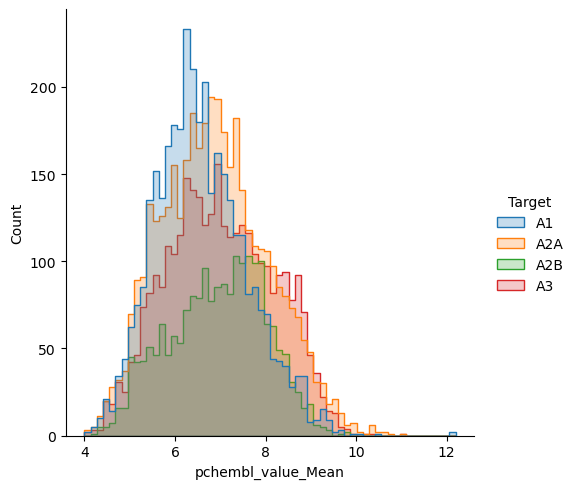

In [81]:
# Define the set of receptors of interest with a label and their Uniprot accession
adenosine_receptors = {'A1': 'P30542',
                       'A2A': 'P29274',
                       'A2B': 'P29275',
                       'A3': 'P0DMS8'}

# Filter the Papyrus bioactivity dataset and plot the distribution of activity values for the targets of interest
ar_data = filter_explore_activity_data(PAPYRUS_VERSION, adenosine_receptors)

#### Align target sequences

In order to ensure protein descriptors are of the same length, we first need to align the target sequences. We do this by using the software ClustalW. The first step is to install the software. Choose one of the following download options depending on your system (Windows, Unix, or MacOS).

##### Clustal Omega downlaod for Windows

In [96]:
# Define url of download file and paths to download
clustalo_url =  "http://www.clustal.org/omega/clustal-omega-1.2.2-win64.zip"
clustalo_zip_path = str(Path(DATA, 'clustalo.zip'))
clustalo_path = str(Path(DATA, 'clustalo'))
# Download .zip installation file
wget.download(clustalo_url, out=clustalo_zip_path)
# Unzip installation file
with zipfile.ZipFile(clustalo_zip_path, 'r') as zip_ref:
    zip_ref.extractall(clustalo_path)
# Define path to executable
clustalo_exe = os.path.join(clustalo_path, 'clustal-omega-1.2.2-win64', 'clustalo.exe')

##### clustalo download for Unix

In [ ]:
# Define url of download file and paths to download
clustalo_url =  "http://www.clustal.org/omega/clustalo-1.2.4-Ubuntu-x86_64"
clustalo_path = str(Path(DATA, 'clustalo'))
# Download executable file
wget.download(clustalo_url, out=clustalo_path)
# Give file executable permission
os.chmod(clustalo_path, 0755)
# Define path to executable
clustalo_exe = clustalo_path

##### clustalo download for MacOS

In [ ]:
# Define url of download file and paths to download
clustalo_url =  "http://www.clustal.org/omega/clustal-omega-1.2.3-macosx"
clustalo_path = str(Path(DATA, 'clustalo'))
# Download executable file
wget.download(clustalo_url, out=clustalo_path)
# Give file executable permission
os.chmod(clustalo_path, 0755)
# Define path to executable
clustalo_exe = clustalo_path

Next, we obtain the protein sequences from the target files in Papyrus.

In [91]:
protein_data = read_protein_set(version=PAPYRUS_VERSION)
sequences = pd.concat(protein_data[protein_data.target_id.str.startswith(x)] for x in adenosine_receptors.values())
sequences

,target_id,HGNC_symbol,UniProtID,Status,Organism,Classification,Length,Sequence
80,P30542_WT,ADORA1,AA1R_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,326,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...
81,P29274_WT,ADORA2A,AA2AR_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,412,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...
47,P29275_WT,ADORA2B,AA2BR_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,332,MLLETQDALYVALELVIAALSVAGNVLVCAAVGTANTLQTPTNYFL...
82,P0DMS8_WT,ADORA3,AA3R_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,318,MPNNSTALSLANVTYITMEIFIGLCAIVGNVLVICVVKLNPSLQTT...


In order to align the sequences with Clustal Omega, we first need to write them into a FASTA file.

In [94]:
records = []
for index, row in sequences.reset_index(drop=True).iterrows():
    records.append(SeqRecord(seq=Seq(row.Sequence),
                             id=str(index),
                             name=row.target_id,
                             description=' '.join([row.UniProtID, row.Organism, row.Classification])))
sequences_path = os.path.join(DATA, 'sequences.fasta')
_ = SeqIO_write(records, sequences_path, 'fasta')

Now, we use Clustal Omega to align the sequences and write out the alignment file.

In [97]:
alignment_file = os.path.join(DATA, 'aligned_sequences.fasta')
clustalomega_cline = ClustalOmegaCommandline(cmd=clustalo_exe, infile=sequences_path, outfile=alignment_file, auto=True)
_ = clustalomega_cline()

Finally we parse the aligned sequences.

In [101]:
aligned_sequences = [str(seq.seq) for seq in SeqIO_parse(alignment_file, 'fasta')]

And we visualize the MSA.

In [112]:
# Read MSA
msa = Bio.AlignIO.read(alignment_file, "fasta")
viewer = RichAlignment(
    names=[record.description for record in msa],
    sequences=[str(record.seq) for record in msa],
)
# Visualize MSA
panel = rich.panel.Panel(viewer, title="Multiple sequence alignment")
rich.print(panel)

╭────────────────────────────────────────── Multiple sequence alignment ──────────────────────────────────────────╮
│ 0 AA1R_HU…     1  ---MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFCFIVSLAVADVAVGALVIPLAILINIGPQTYFHTCLMVACPVLI  │
│ 1 AA2AR_H…     1  ------MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLV  │
│ 2 AA2BR_H…     1  -----MLLETQDALYVALELVIAALSVAGNVLVCAAVGTANTLQTPTNYFLVSLAAADVAVGLFAIPFAITISLGFCTDFYGCLFLACFVLV  │
│ 3 AA3R_HU…     1  MPNNSTALSLANVTYITMEIFIGLCAIVGNVLVICVVKLNPSLQTTTFYFIVSLALADIAVGVLVMPLAIVVSLGITIHFYSCLFMTCLLLI  │
│                                                                                                                 │
│ 0 AA1R_HU…    90  LTQSSILALLAIAVDRYLRVKIPLRYKMVVTPRRAAVAIAGCWILSFVVGLTPMFGWNNLSAVER----AW---AANGSMGEPVIKCEFEKV  │
│ 1 AA2AR_H…    87  LTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWN-------NCGQPKEGKNHSQGCGEGQVACLFEDV  │
│ 2 AA2BR_H…    88  LTQSSIFSLLAVAVDRYLAICVPLRYKSLVTGTRARGVIAVLWVLAFGIGLTPFLGWNSKDSATNNCTEPWDGTTNESCC---LVKCLFENV  │
│ 3 AA3R_HU…    93  FTHASIMSLLAIAVDRYLRVKLTVRYKRVTTHRRIWLALGLCWLVSFLVGLTPMFGWNMKLTSEYHR-------------NVTFLSCQFVSV  │
│                                                                                                                 │
│ 0 AA1R_HU…   175  ISMEYMVYFNFFVWVLPPLLLMVLIYLEVFYLIRKQLNKKVSAS--SGDPQKYYGKELKIAKSLALILFLFALSWLPLHILNCITLFCPSC-  │
│ 1 AA2AR_H…   172  VPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCS  │
│ 2 AA2BR_H…   177  VPMSYMVYFNFFGCVLPPLLIMLVIYIKIFLVACRQLQRTEL----MDHSRTTLQREIHAAKSLAMIVGIFALCWLPVHAVNCVTLFQPAQG  │
│ 3 AA3R_HU…   172  MRMDYMVYFSFLTWIFIPLVVMCAIYLDIFYIIRNKLSLNLSN---SKETGAFYGREFKTAKSLFLVLFLFALSWLPLSIINCIIYFNG---  │
│                                                                                                                 │
│ 0 AA1R_HU…   264  -HKPSILTYIAIFLTHGNSAMNPIVYAFRIQKFRVTFLKIWNDHFRCQPAPPIDEDLPEERPDD---------------

####  Calculate protein descriptors

Now that our protein sequences are aligned, we can calculate protein descriptors

#### Calculate compound descriptors

Explain

### Proteochemometrics modelling

Explain

#### Helper functions

Explain

#### Model training and validation

Explain

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.
Compared to purely ligand-based compound activity prediction models, PCM modelling has certain advantages and limitations.

## Quiz

1. What types of features are needed for PCM?
2. How many types of training/test set splitting methods commonly used in PCM modelling do you know?
3. Which applications do you know of PCM in drug discovery?

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>